mh@'s notebook implementing LoRA

In [115]:
import torch
from transformers import GPTNeoXForCausalLM, AutoTokenizer

model = GPTNeoXForCausalLM.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="./pythia-70m-deduped/step3000",
)

tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="./pythia-70m-deduped/step3000",
)

In [117]:
inputs = tokenizer("Hello, I am", return_tensors="pt")
tokens = model.generate(**inputs)
tokenizer.decode(tokens[0])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
c:\Users\micha\Anaconda3\envs\llm-pdg\Lib\site-packages\transformers\generation\utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'Hello, I am a newbie, and I am a newbie. I am a newbie'

# Plan:
- Rank of the weights?
- LoRA
- Prefix
- average weights of two different loras?

In [121]:
class LoraLinear(torch.nn.Module):
    def __init__(self, linear: torch.nn.Linear, alpha: float= 10, rank: int = 2):
        super().__init__()
        self.old_weights = linear.weight.detach().clone()
        self.old_bias = linear.bias.detach().clone()
        
        # Params
        self.lora_p = torch.nn.Parameter(
            torch.zeros(self.old_weights.shape[0], rank))
        
        self.lora_q = torch.nn.Parameter(
            torch.zeros(self.old_weights.shape[1], rank))
        
        self.scale = torch.nn.Parameter(torch.tensor(alpha)/rank)
        
        # init according to Jörg
        torch.nn.init.kaiming_uniform_(self.lora_p)
        torch.nn.init.zeros_(self.lora_q)
    
    def forward(self, x: torch.Tensor):
        old_linear_result = x@self.old_weights.T + self.old_bias
        # dropped_out_x = torch.nn.Dropout(p=.1)(x)
        # return  old_linear_result + (dropped_out_x@self.lora_p)@self.lora_q.T

        # x @ w.T =  x @ (p @ q.T).T = (x @ q) @ p.T

        return old_linear_result + self.scale * x@(self.lora_q @ self.lora_p.T)

In [122]:
# test = torch.nn.Linear(2,3)
# dict(LoraLinear(test).named_parameters())

In [123]:
import copy

def augment_model_with_lora(model):
    model = copy.deepcopy(model)
    for module_name, module in model.named_modules():
        if module_name.endswith('.attention'):
            # print(module_name, type(module.query_key_value))
            module.query_key_value = LoraLinear(module.query_key_value, rank=16)
    return model

In [124]:
lora_model = augment_model_with_lora(model)

In [125]:
[n for n, p in lora_model.named_parameters() if 'lora' in n or 'scale' in n]

['gpt_neox.layers.0.attention.query_key_value.lora_p',
 'gpt_neox.layers.0.attention.query_key_value.lora_q',
 'gpt_neox.layers.0.attention.query_key_value.scale',
 'gpt_neox.layers.1.attention.query_key_value.lora_p',
 'gpt_neox.layers.1.attention.query_key_value.lora_q',
 'gpt_neox.layers.1.attention.query_key_value.scale',
 'gpt_neox.layers.2.attention.query_key_value.lora_p',
 'gpt_neox.layers.2.attention.query_key_value.lora_q',
 'gpt_neox.layers.2.attention.query_key_value.scale',
 'gpt_neox.layers.3.attention.query_key_value.lora_p',
 'gpt_neox.layers.3.attention.query_key_value.lora_q',
 'gpt_neox.layers.3.attention.query_key_value.scale',
 'gpt_neox.layers.4.attention.query_key_value.lora_p',
 'gpt_neox.layers.4.attention.query_key_value.lora_q',
 'gpt_neox.layers.4.attention.query_key_value.scale',
 'gpt_neox.layers.5.attention.query_key_value.lora_p',
 'gpt_neox.layers.5.attention.query_key_value.lora_q',
 'gpt_neox.layers.5.attention.query_key_value.scale']

## Training

In [126]:
training_set = 'This is PDG!'
training_data = tokenizer(training_set, return_tensors='pt')

# Target generation 
target = torch.concat([
    training_data['input_ids'][:,1:], # Batch x (seq - 1)
    torch.tensor([[tokenizer.eos_token_id]]) # Batch x 1 
    ], axis=-1)

In [128]:
epochs = 300
learning_rate = 1e-4
losses = []

# GPU ? 
# model.to('cuda:0')
# lora_model.to('cuda:0')
# training_data.to('cuda:0')
# target.to('cuda:0')

lora_model.train()
optimizer = torch.optim.Adam(
    params = [p for n, p in lora_model.named_parameters() if 'lora' in n or 'scale' in n],
    lr=learning_rate
)


ce_loss_fn = torch.nn.CrossEntropyLoss()

for step in range(epochs):
    optimizer.zero_grad()
    logits = lora_model(**training_data).logits.permute([0, 2, 1])
    loss = ce_loss_fn(logits, target)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

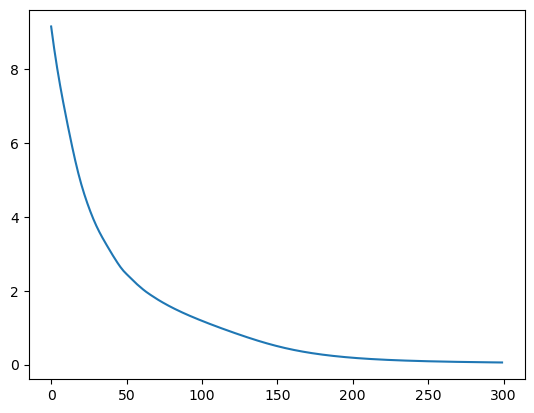

In [129]:
import matplotlib.pyplot as plt

plt.plot(losses);

In [133]:
losses[-1]

0.05810507386922836

In [142]:
lora_model.eval()
inputs = tokenizer("this", return_tensors="pt")
tokens = lora_model.generate(**inputs, pad_token_id=tokenizer.pad_token_id)
tokenizer.decode(tokens[0])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


'this is PDG! DOM-right,\n  \n  \n  \n  \n  \n'

In [132]:
# 1.69 # min loss für sprache? so wie pi und e 

In [144]:
[p for n, p in lora_model.named_parameters() if 'scale' in n]

[Parameter containing:
 tensor(0.6422, requires_grad=True),
 Parameter containing:
 tensor(0.6385, requires_grad=True),
 Parameter containing:
 tensor(0.6414, requires_grad=True),
 Parameter containing:
 tensor(0.6319, requires_grad=True),
 Parameter containing:
 tensor(0.6376, requires_grad=True),
 Parameter containing:
 tensor(0.6412, requires_grad=True)]

In [145]:
10/16

0.625